In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from fit import *
from NEF_RL import simulate_RL, EnvironmentRL
from NEF_WM2 import simulate_WM, EnvironmentWM
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Simulate RL_n and bayes_n with different amounts of noise $\sigma$

In [2]:
def run_bayesn(sid, noise):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    params = [noise, 0]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("bayes_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["bayes_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['noise'] = noise
    return dynamics_data

In [3]:
def run_RLn(sid, sigma):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    params = [mu, sigma]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("RL_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["RL_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['sigma'] = sigma
    return dynamics_data

In [4]:
sid = 18
noises = [0.2, 0.3, 0.5]
dfs = []
for noise in noises:
    dfs.append(run_bayesn(sid, noise))
bayesn_data = pd.concat(dfs, ignore_index=True)

In [5]:
sid = 18
sigmas = [0.03, 0.05, 0.10]
dfs = []
for sigma in sigmas:
    dfs.append(run_RLn(sid, sigma))
RLn_data = pd.concat(dfs, ignore_index=True)

# Simulate NEF_RL or NEF_WM with different number of neurons in various populations

In [6]:
def run_NEF(model_type, sid, n_other, n_error, alpha):
    trials = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")['trial'].unique()    
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'n_other', 'n_error', 'response']
    for trial in trials:
        print(f"{model_type}, n_other {n_other}, n_error {n_error}, sid {sid}, trial {trial}")
        seed_net = sid + 1000*trial
        if model_type=="NEF_RL":
            env = EnvironmentRL(dataset="carrabin", sid=sid, trial=trial)
            net, sim = simulate_RL(env=env, alpha=alpha, n_learning=n_other, n_error=n_error, seed_net=seed_net, progress_bar=False)
        if model_type=="NEF_WM":
            env = EnvironmentWM(dataset="carrabin", sid=sid, trial=trial)
            net, sim = simulate_WM(env=env, alpha=alpha, n_memory=n_other, n_error=n_error, seed_net=seed_net, progress_bar=False)
        for stage in env.stages:
            tidx = int((stage*env.T)/env.dt)-2
            response = np.mean(sim.data[net.probe_value][tidx-100: tidx])
            qid = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid & trial==@trial and stage==@stage")['qid'].unique()[0]
            df = pd.DataFrame([[model_type, sid, trial, stage, qid, n_other, n_error, response]], columns=columns)
            dfs.append(df)
    noise_data = pd.concat(dfs, ignore_index=True)
    return noise_data

In [8]:
sid = 18
alpha = 0.15
n_other = [20, 60]
n_error = [20, 60]
dfs = []
for mt in ['NEF_RL', 'NEF_WM']:
    for n in n_other:
        for e in n_other:
            dfs.append(run_NEF(mt, sid, n, e, alpha))
NEF_data = pd.concat(dfs, ignore_index=True)

sid 18, trial 1
sid 18, trial 2
sid 18, trial 3
sid 18, trial 4
sid 18, trial 5
sid 18, trial 6
sid 18, trial 7
sid 18, trial 8
sid 18, trial 9
sid 18, trial 10
sid 18, trial 11
sid 18, trial 12
sid 18, trial 13
sid 18, trial 14
sid 18, trial 15
sid 18, trial 16
sid 18, trial 17
sid 18, trial 18
sid 18, trial 19
sid 18, trial 20
sid 18, trial 21
sid 18, trial 22
sid 18, trial 23
sid 18, trial 24
sid 18, trial 25
sid 18, trial 26
sid 18, trial 27
sid 18, trial 28
sid 18, trial 29
sid 18, trial 30
sid 18, trial 31
sid 18, trial 32
sid 18, trial 33
sid 18, trial 34
sid 18, trial 35
sid 18, trial 36
sid 18, trial 37
sid 18, trial 38
sid 18, trial 39
sid 18, trial 40
sid 18, trial 41
sid 18, trial 42
sid 18, trial 43
sid 18, trial 44
sid 18, trial 45
sid 18, trial 46
sid 18, trial 47
sid 18, trial 48
sid 18, trial 49
sid 18, trial 50
sid 18, trial 51
sid 18, trial 52
sid 18, trial 53
sid 18, trial 54
sid 18, trial 55
sid 18, trial 56
sid 18, trial 57
sid 18, trial 58
sid 18, trial 59
sid 18

In [10]:
NEF_data.to_pickle(f"data/nef_noise_vs_neurons.pkl")

In [15]:
NEF_data

,type,sid,trial,stage,qid,response,sigma,n_other,n_error
0,RL_n,18,1,1,1,0.209157,0.03,NaN,NaN
1,RL_n,18,1,2,11,0.323056,0.03,NaN,NaN
2,RL_n,18,1,3,111,0.489118,0.03,NaN,NaN
3,RL_n,18,1,4,1110,0.203608,0.03,NaN,NaN
4,RL_n,18,1,5,11101,0.359009,0.03,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10995,NEF_WM,18,200,1,1,0.340458,NaN,60.0,60.0
10996,NEF_WM,18,200,2,11,0.640396,NaN,60.0,60.0
10997,NEF_WM,18,200,3,110,0.161200,NaN,60.0,60.0
10998,NEF_WM,18,200,4,1101,0.464330,NaN,60.0,60.0


### or load

In [39]:
nefrl = pd.read_pickle("data/noise_vs_neurons_NEF_RL_1_feb18.pkl")
nefwm = pd.read_pickle("data/noise_vs_neurons_NEF_WM_1_feb18.pkl")
NEF_load = pd.concat([nefrl, nefwm], ignore_index=True)

## Heatmap plot

In [44]:
def add_excursion_alpha(data):
    dfs = []
    for mt in data['type'].unique():
        for sid in data['sid'].unique():
            human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
            # for n in data['n_other'].unique():
            for n in data['n_learning'].unique():
                for e in data['n_error'].unique():
                    # subdata = data.query("type==@mt & sid==@sid & n_other==@n & n_error==@e").copy()
                    subdata = data.query("type==@mt & sid==@sid & n_learning==@n & n_error==@e").copy()
                    print(f"{mt} sid {sid}, n_other {n}, n_error {e}")
                    for i, row in subdata.iterrows():
                        trial = row['trial']
                        stage = row['stage']
                        qid = row['qid']
                        response = row['response']
                        avg_response = subdata.query("qid==@qid")['response'].mean()
                        subdata.loc[i, 'excursion'] = response - avg_response
                        if stage>1:
                            stage_old = stage - 1
                            response_old = subdata.query("trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
                            delta = response_old - response
                            color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
                            prediction_error = color - response_old
                            alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
                            subdata.loc[i, 'alpha'] = alpha
                    dfs.append(subdata)
    data_add = pd.concat(dfs, ignore_index=True)
    return data_add

In [45]:
NEF_add = add_excursion_alpha(NEF_load)

NEF_RL sid 1, n_other 40, n_error 40
NEF_RL sid 1, n_other 40, n_error 80
NEF_RL sid 1, n_other 40, n_error 120
NEF_RL sid 1, n_other 40, n_error 240
NEF_RL sid 1, n_other 80, n_error 40
NEF_RL sid 1, n_other 80, n_error 80
NEF_RL sid 1, n_other 80, n_error 120
NEF_RL sid 1, n_other 80, n_error 240
NEF_RL sid 1, n_other 120, n_error 40
NEF_RL sid 1, n_other 120, n_error 80
NEF_RL sid 1, n_other 120, n_error 120
NEF_RL sid 1, n_other 120, n_error 240
NEF_RL sid 1, n_other 240, n_error 40
NEF_RL sid 1, n_other 240, n_error 80
NEF_RL sid 1, n_other 240, n_error 120
NEF_RL sid 1, n_other 240, n_error 240
NEF_WM sid 1, n_other 40, n_error 40
NEF_WM sid 1, n_other 40, n_error 80
NEF_WM sid 1, n_other 40, n_error 120
NEF_WM sid 1, n_other 40, n_error 240
NEF_WM sid 1, n_other 80, n_error 40
NEF_WM sid 1, n_other 80, n_error 80
NEF_WM sid 1, n_other 80, n_error 120
NEF_WM sid 1, n_other 80, n_error 240
NEF_WM sid 1, n_other 120, n_error 40
NEF_WM sid 1, n_other 120, n_error 80
NEF_WM sid 1, n_

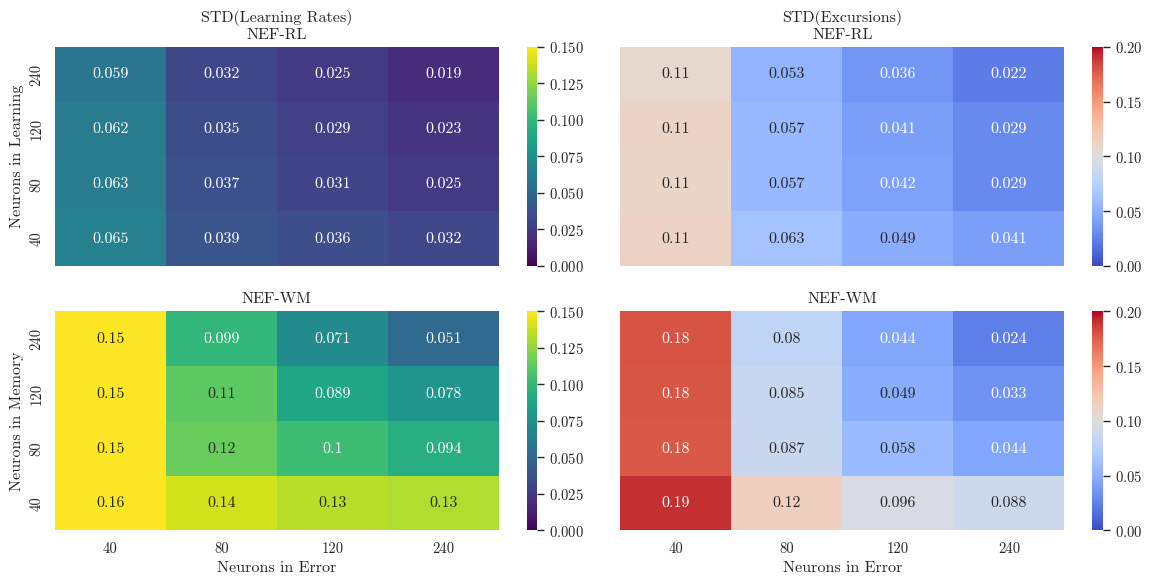

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6), sharex=True, sharey=True)
for mt, model_type in enumerate(['NEF_RL', 'NEF_WM']):
    # alpha_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_other', columns='n_error', values='alpha', aggfunc='std')
    # excursion_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_other', columns='n_error', values='excursion', aggfunc='std')
    alpha_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc='std')
    excursion_pivot = NEF_add.query("type==@model_type").pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc='std')
    sns.heatmap(data=alpha_pivot, annot=True, cmap="viridis", ax=axes[mt][0], vmin=0, vmax=0.15)
    sns.heatmap(data=excursion_pivot, annot=True, cmap="coolwarm", ax=axes[mt][1], vmin=0, vmax=0.2)
    # axes[mt][0].invert_yaxis()
    axes[mt][1].invert_yaxis()
axes[0][0].set(ylabel="Neurons in Learning", xlabel=None, title=f"STD(Learning Rates)\nNEF-RL")
axes[0][1].set(ylabel=None, xlabel=None, title=f"STD(Excursions)\nNEF-RL")
axes[1][0].set(ylabel="Neurons in Memory", xlabel="Neurons in Error", title=f"NEF-WM")
axes[1][1].set(ylabel=None, xlabel="Neurons in Error", title=f"NEF-WM")
plt.tight_layout()
    # fig.savefig("plots/noise_RL_vs_neurons.jpg", dpi=600)

### Compare distribution of alpha, excursions vs above noise parameters

In [49]:
def add_excursion_alpha2(data, noise_label):
    dfs = []
    for mt in data['type'].unique():
        for sid in data['sid'].unique():
            human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
            for n in data[noise_label].unique():
                subdata = data.query(f"type==@mt & sid==@sid & {noise_label}==@n").copy()
                print(f"{mt} sid {sid}, {noise_label} {n}")
                for i, row in subdata.iterrows():
                    trial = row['trial']
                    stage = row['stage']
                    qid = row['qid']
                    response = row['response']
                    avg_response = subdata.query("qid==@qid")['response'].mean()
                    subdata.loc[i, 'excursion'] = response - avg_response
                    if stage>1:
                        stage_old = stage - 1
                        response_old = subdata.query("trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
                        delta = response_old - response
                        color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
                        prediction_error = color - response_old
                        alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
                        subdata.loc[i, 'alpha'] = alpha
                dfs.append(subdata)
    data_add = pd.concat(dfs, ignore_index=True)
    return data_add

In [55]:
rln_add = add_excursion_alpha2(RLn_data, 'sigma')
bayesn_add = add_excursion_alpha2(bayesn_data, 'noise')
human = pd.read_pickle("data/carrabin.pkl").query("sid==@sid")
human['sigma'] = 'human'
human_add = add_excursion_alpha2(human, 'sigma')
human_add['noise'] = 'human'
human_add['n_learning'] = 'human'
human_add['n_error'] = 'human'
rladd = NEF_add.query("type=='NEF_RL' & n_learning==80")
wmadd = NEF_add.query("type=='NEF_WM' & n_learning==80")
# wmadd = NEF_add.query("type=='NEF_WM' & n_memory==80")
combined = pd.concat([human_add, bayesn_add, rln_add, rladd, wmadd], ignore_index=True)

RL_n sid 18, sigma 0.03
RL_n sid 18, sigma 0.05
RL_n sid 18, sigma 0.1
bayes_n sid 18, noise 0.2
bayes_n sid 18, noise 0.3
bayes_n sid 18, noise 0.5
human sid 18, sigma human


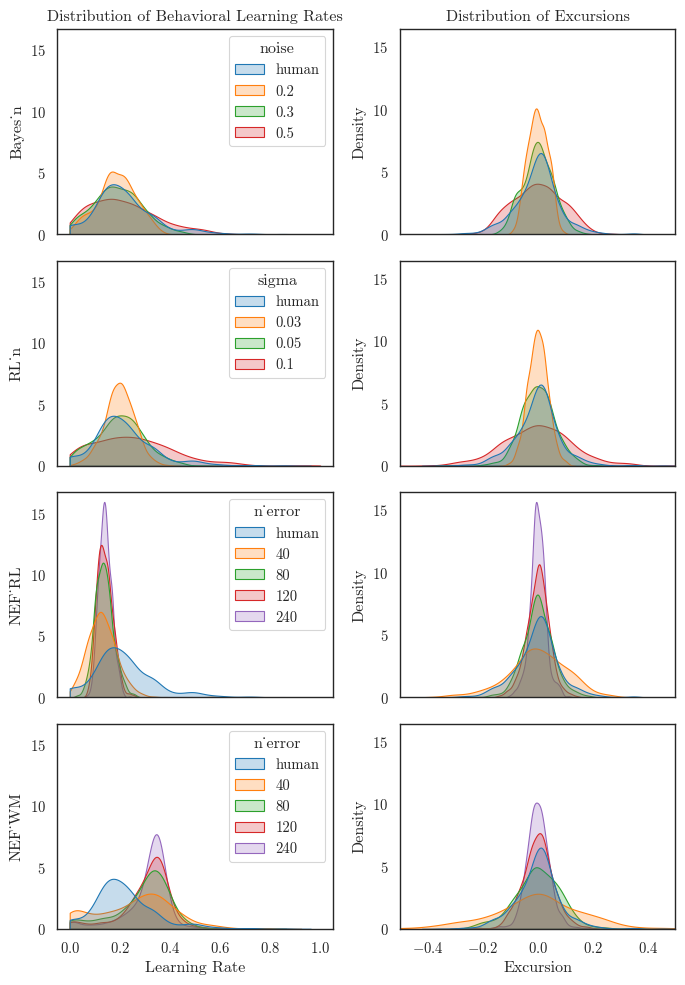

In [59]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(7, 10), sharex='col', sharey='col')
bayes_query = ['human', 'bayes_n']
rl_query = ['human', 'RL_n']
nefrl_query = ['human', 'NEF_RL']
nefwm_query = ['human', 'NEF_WM']
sns.kdeplot(combined.query("type==@bayes_query"), x='alpha', hue='noise', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='alpha', hue='sigma', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefrl_query"), x='alpha', hue='n_error', ax=axes[2][0], clip=[0, 1], palette=palette[:5], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefwm_query"), x='alpha', hue='n_error', ax=axes[3][0], clip=[0, 1], palette=palette[:5], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@bayes_query"), x='excursion', hue='noise', ax=axes[0][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='excursion', hue='sigma', ax=axes[1][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefrl_query"), x='excursion', hue='n_error', ax=axes[2][1], clip=[-1, 1], palette=palette[:5], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nefwm_query"), x='excursion', hue='n_error', ax=axes[3][1], clip=[-1, 1], palette=palette[:5], fill=True, common_norm=False)
axes[0][0].set(title='Distribution of Behavioral Learning Rates')
axes[0][1].set(title='Distribution of Excursions')
axes[0][0].set(ylabel='Bayes_n')
axes[1][0].set(ylabel='RL_n')
axes[2][0].set(ylabel='NEF_RL')
axes[3][0].set(ylabel='NEF_WM')
axes[3][0].set(xlabel="Learning Rate")
axes[3][1].set(xlabel='Excursion', xlim=[-0.5, 0.5])
axes[0][1].get_legend().remove()
axes[1][1].get_legend().remove()
axes[2][1].get_legend().remove()
axes[3][1].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/noise_demo_all_model_types.jpg", dpi=600)

### Compare to distribution of std(alpha) and std(excursion) across human SIDs

In [9]:
human = pd.read_pickle("data/carrabin.pkl")
human['n_learning'] = 'human'
human['n_error'] = 'human'
human_add = add_excursion_alpha(human)
dfs = []
columns = ['type', 'sid', 'std alpha', 'std excursion']
for sid in human_add['sid'].unique():
    std_alpha = human_add.query("sid==@sid")['alpha'].std()
    std_excursion = human_add.query("sid==@sid")['excursion'].std()
    dfs.append(pd.DataFrame([['human', sid, std_alpha, std_excursion]], columns=columns))
human_stds = pd.concat(dfs, ignore_index=True)

human sid 1, n_learning human, n_error human
human sid 2, n_learning human, n_error human
human sid 3, n_learning human, n_error human
human sid 4, n_learning human, n_error human
human sid 5, n_learning human, n_error human
human sid 6, n_learning human, n_error human
human sid 7, n_learning human, n_error human
human sid 8, n_learning human, n_error human
human sid 9, n_learning human, n_error human
human sid 10, n_learning human, n_error human
human sid 11, n_learning human, n_error human
human sid 12, n_learning human, n_error human
human sid 13, n_learning human, n_error human
human sid 14, n_learning human, n_error human
human sid 15, n_learning human, n_error human
human sid 16, n_learning human, n_error human
human sid 17, n_learning human, n_error human
human sid 18, n_learning human, n_error human
human sid 19, n_learning human, n_error human
human sid 20, n_learning human, n_error human
human sid 21, n_learning human, n_error human


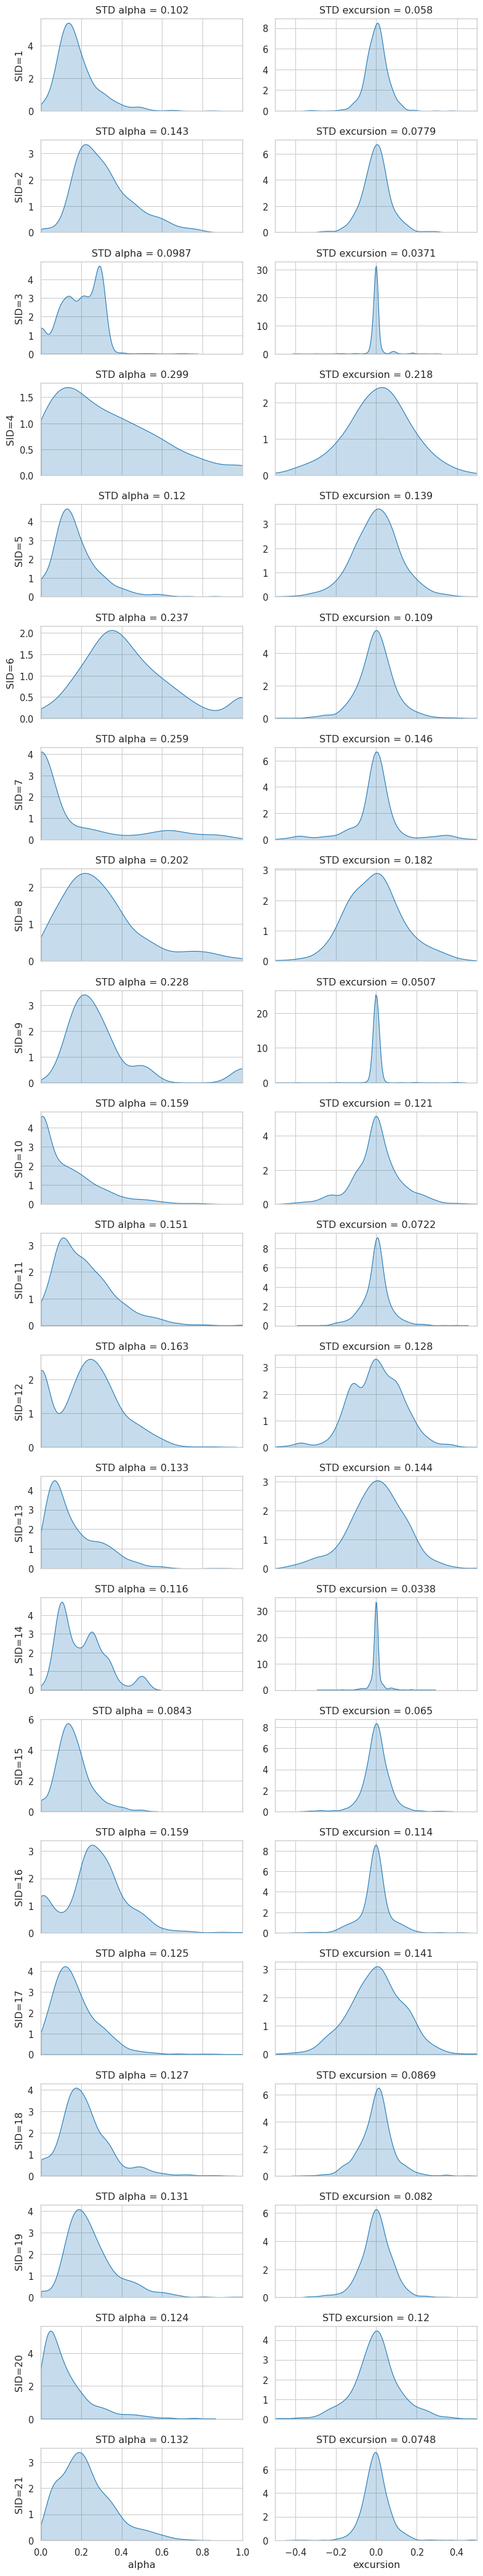

In [10]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=len(human['sid'].unique()), ncols=2, figsize=(8,2*len(human['sid'].unique())), sharex='col')
    for s, sid in enumerate(human['sid'].unique()):
        sns.kdeplot(human_add.query("sid==@sid"), x='alpha', clip=[0,1], ax=axes[s][0], color=palette[0], fill=True, common_norm=False)
        sns.kdeplot(human_add.query("sid==@sid"), x='excursion', clip=[-1,1], ax=axes[s][1], color=palette[0], fill=True, common_norm=False)
        axes[s][0].set(ylabel=f"SID={sid}", title=f"STD alpha = {human_add.query('sid==@sid')['alpha'].std():.3}")
        axes[s][1].set(ylabel=None, title=f"STD excursion = {human_add.query('sid==@sid')['excursion'].std():.3}")
    axes[-1][0].set(xlim=[0,1])
    axes[-1][1].set(xlim=[-0.5,0.5])
    plt.tight_layout()
fig.savefig("plots/alpha_excursions_all_sids.jpg", dpi=600)